# Cleaning

In [2]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
%matplotlib inline
from sklearn.utils import shuffle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions
from sklearn.metrics import accuracy_score,  recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc

In [4]:
#read the file
df = pd.read_csv("german_credit.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   object
 7   installment_rate         1000 non-null   object
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   object
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [8]:
df['amount'].nunique()


923

In [15]:
df['property'].value_counts().tail(10)


building soc. savings agr./life insurance    332
unknown / no property                        282
car or other                                 232
real estate                                  154
Name: property, dtype: int64

In [ ]:
# Assuming df is your dataframe
summary_stats = np.round(df.describe(), 2).T[['count', 'mean', 'std', 'min', 'max']]

# Create LaTeX table with custom formatting
with open('summary_stats.tex', 'w') as f:
    f.write('\\begin{table}[ht]\n')
    f.write('\\centering\n')
    f.write('\\caption{Summary Statistics}\n')
    f.write('\\label{tab:summary_stats}\n')
    f.write('\\begin{tabular}{lcccccc}\n')
    f.write('\\toprule\n')
    f.write(' & \\textbf{Count} & \\textbf{Mean} & \\textbf{Std} & \\textbf{Min} & \\textbf{Max} \\\\\n')
    f.write('\\midrule\n')
    for index, row in summary_stats.iterrows():
        f.write(f'{index} & {row["count"]} & {row["mean"]} & {row["std"]} & {row["min"]} & {row["max"]} \\\\\n')
    f.write('\\bottomrule\n')
    f.write('\\end{tabular}\n')
    f.write('\\end{table}\n')
summary_stats

,count,mean,std,min,max
age,48842.0,38.64,13.71,17.0,90.0
fnlwgt,48842.0,189664.13,105604.03,12285.0,1490400.0
education-num,48842.0,10.08,2.57,1.0,16.0
capital-gain,48842.0,1079.07,7452.02,0.0,99999.0
capital-loss,48842.0,87.50,403.00,0.0,4356.0
hours-per-week,48842.0,40.42,12.39,1.0,99.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df_original_diff = df.copy()
# Summary statistics
summary_stats_diff = df_original_diff.describe(include='all')

# Visualizing the distributions
def plot_distributions(df):
    numeric_columns = df.select_dtypes(include='number').columns
    for column in numeric_columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()
        
    categorical_columns = df.select_dtypes(include='object').columns
    for column in categorical_columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(y=df[column], order=df[column].value_counts().index)
        plt.title(f'Distribution of {column}')
        plt.show()

# Plot distributions for differing instances
plot_distributions(df_original_diff)

one hot encoding for non ordinal

In [38]:
df["credit_history"].value_counts()

no credits taken/all credits paid back duly    530
all credits at this bank paid back duly        293
existing credits paid back duly till now        88
critical account/other credits elsewhere        49
delay in paying off in the past                 40
Name: credit_history, dtype: int64

In [39]:
df['status'] = df['status'].str.replace('... >= 200 DM / salary for at least 1 year', '0')
df['status'] = df['status'].str.replace('no checking account', '1')
df['status'] = df['status'].str.replace('... < 0 DM', '2')
df['status'] = df['status'].str.replace('0<= ... < 200 DM', '3')

In [40]:
df['installment_rate'] = df['installment_rate'].str.replace('< 20', '0')
df['installment_rate'] = df['installment_rate'].str.replace('20 <= ... < 25', '1')
df['installment_rate'] = df['installment_rate'].str.replace('25 <= ... < 35', '2')
df['installment_rate'] = df['installment_rate'].str.replace('>= 35', '3')

In [41]:
# Replace the values in the target column with string '0' and '1'.
df['employment_duration'] = df['employment_duration'].str.replace('< 1 yr', '1')  
df['employment_duration'] = df['employment_duration'].str.replace('unemployed' , '0') 
df['employment_duration'] = df['employment_duration'].str.replace('1 <= ... < 4 yrs', '2')
df['employment_duration'] = df['employment_duration'].str.replace('4 <= ... < 7 yrs', '3')
df['employment_duration'] = df['employment_duration'].str.replace('>= 7 yrs', '4')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   object
 7   installment_rate         1000 non-null   object
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   object
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [43]:
df['present_residence'] = df['present_residence'].str.replace('>= 7 yrs', '0')
df['present_residence'] = df['present_residence'].str.replace('4 <= ... < 7 yrs', '1')
df['present_residence'] = df['present_residence'].str.replace('1 <= ... < 4 yrs', '2')
df['present_residence'] = df['present_residence'].str.replace('< 1 yr', '3')

In [44]:
df['installment_rate'] = df['installment_rate'].astype(int)
df['employment_duration'] = df['employment_duration'].astype(int)
df['present_residence'] = df['present_residence'].astype(int)
df['status'] = df['status'].astype(int)

In [45]:
#Is there any duplicate value in the dataset?
df.duplicated().value_counts()

False    1000
dtype: int64

In [46]:
# Replace the values in the target column with string '0' and '1'.
df['credit_risk'] = df['credit_risk'].str.replace('bad', '0')  
df['credit_risk'] = df['credit_risk'].str.replace('good', '1')   

# Convert to integer
df['credit_risk'] = df['credit_risk'].astype(int)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   int32 
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   int32 
 7   installment_rate         1000 non-null   int32 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   int32 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

# 2. Split data into separate fitting and test set

In [48]:
# From X set, education column is also dropped as it is similar to Education-num
X = df.drop(['credit_risk'], axis=1)

y = df['credit_risk']

In [49]:
# Split the dataset into fitting data (60%) and test set (40%)
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.3, random_state=1155)

# 3. Random Forest and Logistig Regression

### Defining Random Forest and Logistic Regression model

In [50]:
#Defining Random Forest model
def run_RF (X_fit, y_fit, X_test, y_test, model_name, i, j , k, estimator, depth):
    # Preprocessing for cataegorical data - OneHotEncoding
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    # Preprocessing for numerical data - StandardScaler
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # Bundle preprocessing for numerical and categorical data
    transformations = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical),  
            ('cat', categorical_transformer, categorical)],
        remainder='passthrough')
    
    clf_RF = Pipeline(steps=[('preprocessor', transformations), 
                             ('classifier', RandomForestClassifier(n_estimators=estimator, max_depth=depth))])
    model_RF = clf_RF.fit(X_fit, y_fit)
    y_pred_rf = model_RF.predict(X_test)

    f1_rf = f1_score(y_test, y_pred_rf)
    roc_rf = roc_auc_score(y_test, y_pred_rf)
    a = len(X_fit)
    # Saving the model performance metrics
    if depth == None:
        models_rf = [('RF_{}'.format(model_name), k, j, i, a, f1_rf, roc_rf, 0, 0)]
    else:
        models_rf = [('RF_simp_{}'.format(model_name), k, j, i, a, f1_rf, roc_rf, 0, 0)]
    # Saving the model performance metrics in a dataframe
    model_perf_metrics_rf = pd.DataFrame(models_rf, columns = ['Model', 'Iteration', 'Sample Size', 'CF Num', 'X_fit Size',  'F1 (%)', 'AUC (%)', 'F1 (%)_std', 'AUC (%)_std'])
      
    return model_RF, model_perf_metrics_rf, roc_rf, f1_rf

In [51]:
#Defining Logistic Regression
def run_LR(X_fit, y_fit, X_test, y_test, model_name, i, j , k):

    # Preprocessing for categorical data - OneHotEncoding
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Preprocessing for numerical data - StandardScaler
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
# Bundle preprocessing for numerical and categorical data
    transformations = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical),  
            ('cat', categorical_transformer, categorical)], 
        remainder='passthrough')

# Logistic Regression
    clf_LR = Pipeline(steps=[('preprocessor', transformations), ('classifier', LogisticRegression(max_iter=1000))])
    model_LR = clf_LR.fit(X_fit, y_fit)
    y_pred_lr = model_LR.predict(X_test)

    f1_lr = f1_score(y_test, y_pred_lr)
    roc_lr = roc_auc_score(y_test, y_pred_lr)
    a = len(X_fit)

    # Saving the model performance metrics
    models_lr = [('LR_{}'.format(model_name), k, j, i, a, f1_lr, roc_lr, 0, 0)]
    # Saving the model performance metrics in a dataframe
    model_perf_metric_lr = pd.DataFrame(models_lr, columns = ['Model', 'Iteration', 'Sample Size', 'CF Num','X_fit Size', 'F1 (%)', 'AUC (%)', 'F1 (%)_std', 'AUC (%)_std'])

    return  model_perf_metric_lr, roc_lr, f1_lr

### Defining Decision Tree

In [52]:

def run_DT(X_fit, y_fit, X_test, y_test, model_name, i, j , k):
    # Preprocessing for cataegorical data - OneHotEncoding
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
        # Preprocessing for numerical data - StandardScaler
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
    # Bundle preprocessing for data
    transformations = ColumnTransformer(
        transformers=[            
            ('num', numerical_transformer, numerical),  
            ('cat', categorical_transformer, categorical)],
        remainder='passthrough')
    
        # Initialize the decision tree classifier
    clf_DT = Pipeline(steps=[('preprocessor', transformations), ('classifier', DecisionTreeClassifier())])
    
    # Train the classifier using the fit data
    model_DT = clf_DT.fit(X_fit, y_fit)
    # Make predictions on the test data
    y_pred_dt = model_DT.predict(X_test)

    # Calculate the needed model performance metrics
    f1_dt = f1_score(y_test, y_pred_dt)
    roc_dt = roc_auc_score(y_test, y_pred_dt)
    a = len(X_fit)

    # Saving the model performance metrics
    models_dt = [('DT_{}'.format(model_name), k, j, i, a, f1_dt, roc_dt, 0, 0)]
    # Saving the model performance metrics in a dataframe
    model_perf_metrics_dt = pd.DataFrame(models_dt, columns = ['Model', 'Iteration', 'Sample Size', 'CF Num', 'X_fit Size',  'F1 (%)', 'AUC (%)', 'F1 (%)_std', 'AUC (%)_std'])
        
    return model_perf_metrics_dt, roc_dt, f1_dt

### Running the default models one time and saving the performance metrics

In [53]:
def run_models_and_merge_metrics(X_fit, y_fit, X_test, y_test):
    """
    Trains Random Forest and Logistic Regression models on the given training data,evaluates their performance on the test data, and merges their performance metrics into two dataframes.

    Parameters:
    X_fit (DataFrame): Features for training the models.
    y_fit (Series): Target variable for training the models.
    X_test (DataFrame): Features for testing the models.
    y_test (Series): Target variable for testing the models.

    Returns:
    tuple: 
        - model_RF (RandomForestClassifier): The trained Random Forest model.
        - model_perf_metrics_merged (DataFrame): Dataframe containing merged performance metrics of the Random Forest and Logistic Regression models.
        - model_perf_metrics_merged_only_with_cfs (DataFrame): Another dataframe containing merged performance metrics, identical to the first but intended for use with a counterfactuals dataset.
    """
   
    # Running default Random Forest Once
    model_RF, model_perf_metric_rf, roc_rf, f1_rf = run_RF(X_fit, y_fit, X_test, y_test, 'default', 0, 0, 0, 100, None)
    # Running default Logistic Regression Once
    model_perf_metric_lr, auc, f1 = run_LR(X_fit, y_fit, X_test, y_test, 'default', 0, 0, 0)
    
    # Merging the default model performance metrics in a dataframe to accommodate new models, and doing it twice to use the second one on only CFs dataset.
    model_perf_metrics_merged = model_perf_metric_rf.merge(model_perf_metric_lr, how='outer')
    model_perf_metrics_merged_only_with_cfs = model_perf_metric_rf.merge(model_perf_metric_lr, how='outer')
    
    return model_RF, model_perf_metrics_merged, model_perf_metrics_merged_only_with_cfs


### Running the default models multiple times and saving the performance metrics

In [54]:
def mean_of_default_models (k):
    """
    Computes the mean and standard deviation of model performance metrics for default Random Forest and Logistic Regression models over multiple iterations.

    Parameters:
    k (int): The number of iterations to run the models for calculating the mean and standard deviation.

    Returns:
    model_perf_metrics_mean_of_iterations_only_with_cfs (pandas.DataFrame): DataFrame containing the mean and standard deviation of performance metrics for Random Forest and Logistic Regression models trained only on CFs.
    model_perf_metrics_mean_of_iterations (pandas.DataFrame): DataFrame containing the mean and standard deviation of performance metrics for Random Forest and Logistic Regression models trained on original data.
    """
    total_auc_rf = []
    total_f1_rf = []
    total_auc_lr = []
    total_f1_lr = []
    
    for k in range(0, k):    
        #Running default RF and LR
        _, _ ,auc_def_rf,f1_def_rf = run_RF(X_fit, y_fit, X_test, y_test, 'default', 0 , 0 , 0, 100, None)
        _ , auc_def_lr, f1_def_lr = run_LR(X_fit, y_fit, X_test, y_test, 'default', 0 , 0 , 0)
        
        # Creating a list appending the auc and f1 scores of each iteration to calculate mean in at the end of the iterations.
        total_auc_rf.append(auc_def_rf)
        total_auc_lr.append(auc_def_lr)
        total_f1_rf.append(f1_def_rf)
        total_f1_lr.append(f1_def_lr)
    else:
        # Means            
        total_auc_rf_mean = np.mean(total_auc_rf)
        total_f1_rf_mean = np.mean(total_f1_rf)

        total_auc_lr_mean = np.mean(total_auc_lr)
        total_f1_lr_mean = np.mean(total_f1_lr)

        # Standart  deviations
        total_auc_rf_std = round(np.std(total_auc_rf),8)
        total_f1_rf_std = round(np.std(total_f1_rf),8)

        total_auc_lr_std = round(np.std(total_auc_lr),8)
        total_f1_lr_std = round(np.std(total_f1_lr),8)

        c = len(X_fit)
        
        model_perf_metrics_mean_of_iterations_only_with_cfs = pd.DataFrame()
        model_perf_metrics_mean_of_iterations = pd.DataFrame()
        
        default_RF_means_row = {'Model': 'RF_default_mean_of_iterations', 'Iteration': k+1, 'Sample Size': 0, 'CF Num': 0, 'X_fit Size':c ,
        'F1 (%)': total_f1_rf_mean, 'F1 (%)_std':total_f1_rf_std, 'AUC (%)' :total_auc_rf_mean, 'AUC (%)_std': total_auc_rf_std}
        
        model_perf_metrics_mean_of_iterations_only_with_cfs = model_perf_metrics_mean_of_iterations_only_with_cfs.append(default_RF_means_row, ignore_index=True)
        model_perf_metrics_mean_of_iterations = model_perf_metrics_mean_of_iterations.append(default_RF_means_row, ignore_index=True)   
       
        default_LR_means_row = {'Model': 'LR_default_mean_of_iterations', 'Iteration': k+1, 'Sample Size': 0, 'CF Num': 0, 'X_fit Size':c ,
        'F1 (%)': total_f1_lr_mean, 'F1 (%)_std':total_f1_lr_std, 'AUC (%)' :total_auc_lr_mean, 'AUC (%)_std': total_auc_lr_std}

        model_perf_metrics_mean_of_iterations_only_with_cfs = model_perf_metrics_mean_of_iterations_only_with_cfs.append(default_LR_means_row, ignore_index=True)
        model_perf_metrics_mean_of_iterations = model_perf_metrics_mean_of_iterations.append(default_LR_means_row, ignore_index=True)
    
        return model_perf_metrics_mean_of_iterations_only_with_cfs, model_perf_metrics_mean_of_iterations

### Calculating the means and standart deviations of multiple iterations

In [55]:
def calculate_means_and_stds(total_auc_cf, total_f1_cf, total_auc, total_f1, i, j, k, a, b):
    """
    Calculates the mean and standard deviation of model performance metrics for each iterations and constructs summary rows for inclusion in a DataFrame.

    Parameters:
    total_auc_cf (list): AUC scores for models trained only on counterfactuals across iterations.
    total_f1_cf (list): F1 scores for models trained only on counterfactuals across iterations.
    total_auc (list): AUC scores for models trained on original data plus counterfactuals across iterations.
    total_f1 (list): F1 scores for models trained on original data plus counterfactuals across iterations.
    i (int): The number of counterfactuals to be generated for each sample, for the experiment.
    j (int): The sample size to be used for counterfactual generation, for the experiment.
    k (int): The number of iterations to be run for each sample size and CF number combination.
    a (int): The size of the training dataset including original data plus counterfactuals.
    b (int): The size of the training dataset with only counterfactuals.

    Returns:
    new_row (dict): A dictionary containing the mean and standard deviation of performance metrics for models trained on original data plus counterfactuals.
    new_row_cf (dict): A dictionary containing the mean and standard deviation of performance metrics for models trained only on counterfactuals.
    """
        
    total_auc_only_cf_mean = np.mean(total_auc_cf)
    total_f1_only_cf_mean = np.mean(total_f1_cf)

    total_auc_mean = np.mean(total_auc)
    total_f1_mean = np.mean(total_f1)

    #Standart  deviations
    total_auc_only_cf_std = round(np.std(total_auc_cf),8)
    total_f1_only_cf_std = round(np.std(total_f1_cf),8)

    total_auc_std = round(np.std(total_auc),8)
    total_f1_std = round(np.std(total_f1),8)
    
    new_row   = {'Model': 'LR_sample:{}_cf:{}_mean_of_{}_iterations'.format(j, i, k), 'Iteration': k, 'Sample Size': j, 'CF Num': i, 'X_fit Size':a ,
                             'F1 (%)': total_f1_mean, 'F1 (%)_std':total_f1_std, 'AUC (%)' :total_auc_mean, 'AUC (%)_std': total_auc_std}
 
                # Creating new rows to save the model performance metrics of each sample size and CF number combination's all iterations
    new_row_cf= {'Model': 'LR_sample:{}_cf:{}_mean_of_{}_iterations_only_cf'.format(j, i, k) , 'Iteration': k, 'Sample Size': j, 'CF Num': i, 'X_fit Size':b , 
                             'F1 (%)': total_f1_only_cf_mean, 'F1 (%)_std': total_f1_only_cf_std, 'AUC (%)' :total_auc_only_cf_mean, 'AUC (%)_std': total_auc_only_cf_std}
    return new_row, new_row_cf

# 4. Plots

In [56]:
def distrubution_plot(df, name, true_false_1, true_false_2):
    """
    This function plots the distribution of scores for a given model.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the model performance data.
    name (str): The list of the Scores that will be plotted.
    1st True False is a flag to determine if the data is mean of iterations or not.
    2nd True False is a flag to determine if the data is only CFs or CFs + original data.    
    """
    # Get the default values of the models
    lr_line = df[df['Model'].str.startswith('LR_default')][name].iloc[0]
    rf_line = df[df['Model'].str.startswith('RF_default')][name].iloc[0]
    df = df[(df['Model'] != 'RF_default') & (df['Model'] != 'LR_default')]
    df = df[(df['Model'] != 'RF_default_mean_of_iterations') & (df['Model'] != 'LR_default_mean_of_iterations')]

    # Get the sample size, CF Num and Iteration values    
    x = df['Sample Size'].unique()
    x_2 = df['CF Num'].unique()
    x_3 = df['Iteration'].unique()

    # Get the y values
    y = df[name]
    y_err = df[name+'_std']
    # combine x and x_2 for x-axis labels
    combined_x = [f"{i}_{j}_{k}" for i in x for j in x_2 for k in x_3]

    # plot lines
    plt.figure(figsize=(25,10))
    
    
    # 1st True False is a flag to determine if the data is mean of iterations or not. True = mean of iterations
    # 2nd True False is a flag to determine if the data is only CFs or CFs + original data. True = only CFs
    if true_false_1 is True:
        plt.scatter(combined_x, y, color="blue")
        plt.errorbar(combined_x, y, yerr=y_err, fmt='o', color="blue",  capsize=6, label="{} Values".format(name))

        plt.axhline(y=rf_line, color='r', linestyle='--', label="Default_RF_Line_Mean_of_{}".format(x_3))  # Plot RF_line as a horizontal line
        plt.axhline(y=lr_line, color='green', linestyle='--', label="Default_LR_line_Mean_of_{}".format(x_3))  # Plot LR_line as a horizontal line

        plt.ylabel('{} score'.format(name))
        plt.xlabel('Sample Size- CF Num- Iteration')
        plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.155))
        plt.xticks(rotation=40)  # rotate x-axis labels for better visibility        
        
        if true_false_2 is True:
            plt.title('Distribution of {} Scores of Models\n Trained on CFs\nSample: {} - CF: {}\n Mean of {} iterations'.format(name,x, x_2, x_3))
            plt.savefig(f"Plots/Plot_of_{name}_Score_onlyCFs_Sample_{x}_CF_{x_2}_mean_of_{x_3}_iterations.svg", format='svg')    
        else:
            plt.title('Distribution of {} Scores \n Trained on CFs + Original set\n Sample: {} - CF: {}\n Mean of {} iterations'.format(name,x, x_2, x_3))
            plt.savefig(f"Plots/Plot_of_{name}_Score_Sample_{x}_CF_{x_2}_mean_of_{x_3}_iterations.svg", format='svg')    
    else:
        plt.plot(combined_x, y, 'o-', color="blue", label="{} Values".format(name))
        
        plt.axhline(y=rf_line, color='r', linestyle='--', label="Default_RF_Line")  # Plot RF_line as a horizontal line
        plt.axhline(y=lr_line, color='green', linestyle='--', label="Default_LR_line")  # Plot LR_line as a horizontal line

        plt.ylabel('{} score'.format(name))
        plt.xlabel('Sample Size- CF Num- Iteration')
        plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.155))
        plt.xticks(rotation=40)  # rotate x-axis labels for better visibility    

        if true_false_2 is True:
            plt.title('Distribution of {} Scores of Models \nTrained on CFs\nSample: {} - CF: {}'.format(name, x, x_2))
            plt.savefig(f"Plots/Plot_of_{name}_Score_onlyCFs_Sample_{x}_CF_{x_2}.svg", format='svg')
        else:    
            plt.title('Distribution of {} Scores \n Trained on CFs + Original set\n Sample: {} - CF: {}'.format(name, x, x_2))
            plt.savefig(f"Plots/Plot_of_{name}_Score_Sample_{x}_CF_{x_2}.svg", format='svg')
            
    #plt.show()

# 5. Counterfactuals

In [57]:
def generate_counterfactuals(X_fit, y_fit, model, continuous_features, sample_size, total_CFs, fea_to_vary, k ):
    
    all_columns = X_fit.columns
    # Calculate the original class distribution
    class_0_count = np.sum(y_fit == 0)
    class_1_count = np.sum(y_fit == 1)

    # Calculate the opposite class distribution proportions
    total_count = class_0_count + class_1_count
    prop_class_0 = class_1_count / total_count
    prop_class_1 = class_0_count / total_count

    # Determine the number of samples for each class in the opposite distribution
    total_samples = sample_size
    num_class_0_samples = int(total_samples * prop_class_0)
    num_class_1_samples = total_samples - num_class_0_samples  # Ensuring total is 1000

    # Sample from each class to get the opposite distribution
    X_class_0 = X_fit[y_fit == 0]
    X_class_1 = X_fit[y_fit == 1]

    y_class_0 = y_fit[y_fit == 0]
    y_class_1 = y_fit[y_fit == 1]

    # Sample the required number of samples from each class
    X_class_0_sampled, _, y_class_0_sampled, _ = train_test_split(X_class_0, y_class_0, train_size=num_class_0_samples, random_state=42)
    X_class_1_sampled, _, y_class_1_sampled, _ = train_test_split(X_class_1, y_class_1, train_size=num_class_1_samples, random_state=42)

    # Convert the sampled numpy arrays back to DataFrames
    X_class_0_sampled_df = pd.DataFrame(X_class_0_sampled, columns=all_columns)
    X_class_1_sampled_df = pd.DataFrame(X_class_1_sampled, columns=all_columns)

    # Concatenate DataFrames
    X_fit = pd.concat([X_class_0_sampled_df, X_class_1_sampled_df], ignore_index=True)
    # Assuming y_class_0_sampled, y_class_1_sampled are numpy arrays with single column
    y_fit = pd.DataFrame(np.concatenate([y_class_0_sampled, y_class_1_sampled]), columns=[outcome_name])
    # Optionally, shuffle the dataset to mix the classes
    X_fit, y_fit = shuffle(X_fit, y_fit, random_state=42)

    # Create a Dice-ML data object
    d = dice_ml.Data(dataframe=X_fit.assign(credit_risk=y_fit), continuous_features=continuous_features, outcome_name=outcome_name)
    # Creating a Model object
    m = dice_ml.Model(model=model, backend="sklearn")
    # Creating the DICE model with data and model object 
    exp = dice_ml.Dice(d, m, method="random")

    # Execution of the DICE model to generate counterfactuals
    e1 = exp.generate_counterfactuals(X_fit, total_CFs=total_CFs, desired_class="opposite", features_to_vary= fea_to_vary)
    
    # Comment out the below line as CFs needed to be visualized in the notebook
    #e1.visualize_as_dataframe(show_only_changes=True)

    # Creating a new empty dataframe to store the generated CFs
    cf_df = pd.DataFrame()
    # For loop to append the counterfactuals of each sample, to a dataframe
    for i in range(0, sample_size):
        # Saving CFs
        xd = e1.cf_examples_list[i].final_cfs_df
        # Adding the generated CFs to the empty dataframe
        cf_df = pd.concat([cf_df, xd])
# If the sample size is reached and the CFs are generated for all the samples, followiing code resets the index of the dataframe and saves the generated CFs as a csv file.
    else:
        # Resetting the index of the dataframe to not have duplicate index number
        cf_df.reset_index(drop=True, inplace=True)
        new_start_index = len(X_fit) + i + len(cf_df)
        cf_df.index += new_start_index 
        # Saving the generated CFs as a csv file
        cf_df.to_csv('Generated_CFs/cf_df_{}_{}_{}.csv'.format(sample_size, total_CFs,k ))
        
        # Following code creates X and y fit sets for the generated CFs and returns them for further use.
        X_fit_cf = cf_df.drop([outcome_name], axis=1)
        y_fit_cf = cf_df[outcome_name]

    return X_fit_cf, y_fit_cf, cf_df

# Defining a experiment  fuction that runs the RF and LR, DICE model that generates counterfactuals, and then using those CFs for more model traning. 
#### Then the function saves these CF explanations into a dataframe and trains the LR again with the generated CFs. At the same time, model appends the original fit-set to CF dataset and trains the LR again with the combined version of the datasets. For each model training, LR model function appends the new model performance metrics into a dataframe. Possible adjustments that can be made are, 
- continuous features, 
- size of the sample that will be used to create the CFs, 
- how many CFs to generate per one sample,
- how many iterations will be made for each sample_size and CF_number pair,
- which features can vary in the CF generation process.

In [58]:
def running_exp (X_fit, y_fit, X_test, y_test, continuous_features, sample_size_list, total_CFs_list, iteration_num, fea_to_vary, name_of_the_exp, list_of_models):
    """
    This function is for running the experiments with different sample sizes, CF numbers and iterations.

    Parameters:
    X_fit (pandas.DataFrame): The training dataset.
    y_fit (pandas.Series): The target variable of the training dataset.
    X_test (pandas.DataFrame): The test dataset.
    y_test (pandas.Series): The target variable of the test dataset.
    continuous_features (list): The list of continuous features in the dataset.
    sample_size_list (list): The list of sample sizes to be used in the experiments.
    total_CFs_list (list): The list of total CF numbers to be generated for each sample size.
    iteration_num (int): The number of iterations to be run for each sample size and CF number combination.
    fea_to_vary (list): The list of features to be varied in the CF generation process. Other features will be kept constant.
    num (int): The number to be added to the file names to distinguish the results of different experiments.
    list_of_models (list): The names of the Scores to be plotted. For example, AUC or F1.

    Returns:
    model_perf_metrics_merged_with_for_cfs (pandas.DataFrame): The model performance metrics of the experiments trained with only CFs.
    model_perf_metrics_merged (pandas.DataFrame): The model performance metrics of the experiments trained with CFs and original data.
    new_cf_df (pandas.DataFrame): All generated CFs in every CF number, sample size and iterations.
    """
    new_cf_df = pd.DataFrame()

    # Running the default Random Forest and Logistic Regression models once and merging their performance metrics in a dataframe.
    model_RF, model_perf_metrics_merged_only_with_cfs , model_perf_metrics_merged= run_models_and_merge_metrics(X_fit, y_fit, X_test, y_test)
    
    # Running the default RF and LR models for multiple iterations to calculate the mean and standard deviation of the performance metrics.
    model_perf_metrics_mean_of_iterations_only_with_cfs, model_perf_metrics_mean_of_iterations = mean_of_default_models (iteration_num)

    # Saving these new rows to the model performance metrics dataframes    
    # Loop through different sample sizes
    for j in sample_size_list:
        # Loop through different total CF numbers
        for i in total_CFs_list:
            # Initializing empty lists for saving auc and f1 scores for each iteration
            total_f1_cf = []
            total_f1 = []
            total_auc_cf = []
            total_auc = []

            # Loop through iteration numbers, doing a new experiment for each sample_size and CF_number combination
            for k in range(1,iteration_num+1):    
                # Generating counterfactuals using the 'generate_counterfactuals' function
                X_fit_cf, y_fit_cf, cf_df = generate_counterfactuals(X_fit, y_fit, model_RF, continuous_features, j, i, fea_to_vary, k)
                # Concatenating the original dataset with the generated CFs dataset
                # 
                new_cf_df = new_cf_df.append(cf_df)
                new_X_fit = pd.concat([X_fit, X_fit_cf])
                new_y_fit = pd.concat([y_fit, y_fit_cf])

                # Running the Logistic Regression model on the CFs dataset and the dataset with original X_fit plus CFs.
                model_perf_metric_lr_only_cf, auc_only_cf, f1_only_cf = run_LR(X_fit_cf, y_fit_cf, X_test, y_test, 'sample:{}_cf:{}_iteration:{}'.format(j, i, k), i , j , k)
                model_perf_metric_lr_cf_org, auc_lr_cf, f1_lr_cf = run_LR(new_X_fit, new_y_fit, X_test, y_test, 'sample:{}_cf:{}_iteration:{}'.format(j, i, k), i , j , k)                
                
                # Running the Random Forest model on the CFs dataset and the dataset with original X_fit plus CFs.
                #_,model_perf_metric_rf_only_cf, auc_only_cf, f1_only_cf = run_RF(X_fit_cf, y_fit_cf, X_test, y_test, 'sample:{}_cf:{}_iteration:{}'.format(j, i, k), i , j , k)
                #_, model_perf_metric_rf_cf_org, auc_rf_cf, f1_rf_cf = run_RF(new_X_fit, new_y_fit, X_test, y_test, 'sample:{}_cf:{}_iteration:{}'.format(j, i, k), i , j , k)
                
                # Creating a list appending the auc and f1 scores of each iteration to calculate mean in at the end of the iterations.
                total_f1_cf.append(f1_only_cf)
                total_f1.append(f1_lr_cf)
                total_auc_cf.append(auc_only_cf)
                total_auc.append(auc_lr_cf)

                # Saving the model performance metrics of each iteration
                model_perf_metrics_merged_only_with_cfs = model_perf_metrics_merged_only_with_cfs.append(model_perf_metric_lr_only_cf, ignore_index=True)
                model_perf_metrics_merged = model_perf_metrics_merged.append(model_perf_metric_lr_cf_org, ignore_index=True)
                
            else:
            # Calculate means and standard deviations of auc and f1 scores of all the iterations for each sample size and CF number combination
                a = len(new_X_fit)
                b = len(X_fit_cf)

                new_row, new_row_cf = calculate_means_and_stds(total_auc_cf, total_f1_cf, total_auc, total_f1, i, j, k, a, b)
            
                # Saving these new rows to the model performance metrics dataframes    
                model_perf_metrics_mean_of_iterations_only_with_cfs = model_perf_metrics_mean_of_iterations_only_with_cfs.append(new_row_cf, ignore_index=True)
                model_perf_metrics_mean_of_iterations = model_perf_metrics_mean_of_iterations.append(new_row, ignore_index=True)
                
    # Saving the model performance metrics of each iteration as excel files after all the experiments are done.
    model_perf_metrics_merged_only_with_cfs.to_excel('Performance_metrics/model_perf_metrics_merged_only_with_cfs_{}.xlsx'.format(name_of_the_exp))
    model_perf_metrics_merged.to_excel('Performance_metrics/model_perf_metrics_merged_{}.xlsx'.format(name_of_the_exp))
    # Saving the MEAN model performance metrics of each iteration as excel files after all the experiments are done.
    model_perf_metrics_mean_of_iterations_only_with_cfs.to_excel('Performance_metrics/model_perf_metrics_mean_of_iterations_only_with_cfs_{}.xlsx'.format(name_of_the_exp))
    model_perf_metrics_mean_of_iterations.to_excel('Performance_metrics/model_perf_metrics_mean_of_iterations_{}.xlsx'.format(name_of_the_exp))
    
    for k in list_of_models:
        # k is the list of the Scores to be plotted
        # 1st True False is a flag to determine if the data is mean of iterations or not. True = mean of iterations
        # 2nd True False is a flag to determine if the data is only CFs or CFs + original data. True = only CFs
        distrubution_plot(model_perf_metrics_merged, k, False, False )
        distrubution_plot(model_perf_metrics_merged_only_with_cfs, k, False, True )

        distrubution_plot(model_perf_metrics_mean_of_iterations, k, True , False)
        distrubution_plot(model_perf_metrics_mean_of_iterations_only_with_cfs, k, True, True )
        
    return  model_perf_metrics_merged_only_with_cfs, model_perf_metrics_merged, new_cf_df

In [59]:
X_fit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 90 to 96
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   700 non-null    int32 
 1   duration                 700 non-null    int64 
 2   credit_history           700 non-null    object
 3   purpose                  700 non-null    object
 4   amount                   700 non-null    int64 
 5   savings                  700 non-null    object
 6   employment_duration      700 non-null    int32 
 7   installment_rate         700 non-null    int32 
 8   personal_status_sex      700 non-null    object
 9   other_debtors            700 non-null    object
 10  present_residence        700 non-null    int32 
 11  property                 700 non-null    object
 12  age                      700 non-null    int64 
 13  other_installment_plans  700 non-null    object
 14  housing                  700 non-null    o

In [60]:
X_fit.head(5)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
90,2,12,all credits at this bank paid back duly,others,1995,... < 100 DM,1,0,male : married/widowed,none,3,building soc. savings agr./life insurance,27,none,rent,1,skilled employee/official,0 to 2,no,no
473,0,15,no credits taken/all credits paid back duly,car (used),2186,... >= 1000 DM,3,3,female : non-single or male : single,none,0,unknown / no property,33,bank,for free,1,unskilled - resident,0 to 2,no,no
330,0,24,all credits at this bank paid back duly,repairs,1927,... >= 1000 DM,2,1,female : non-single or male : single,none,2,building soc. savings agr./life insurance,33,none,rent,3-Feb,skilled employee/official,0 to 2,yes (under customer name),no
98,1,9,no credits taken/all credits paid back duly,car (used),2136,unknown/no savings account,2,1,male : married/widowed,none,2,unknown / no property,25,none,rent,1,skilled employee/official,0 to 2,no,no
11,1,30,all credits at this bank paid back duly,car (new),6187,... < 100 DM,3,3,female : single,none,0,building soc. savings agr./life insurance,24,none,for free,3-Feb,skilled employee/official,0 to 2,no,no


In [61]:
# Defining the columns' categories
numerical = ['duration',  'amount', 'age', 'employment_duration','installment_rate', 'present_residence']
categorical = ['status','personal_status_sex', 'property', 'other_installment_plans', 'housing', 'credit_history', 'purpose',
               'savings', 'other_debtors', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker' ]
continuous_features = ['amount']
outcome_name = 'credit_risk'


100%|██████████| 240/240 [00:49<00:00,  4.81it/s]


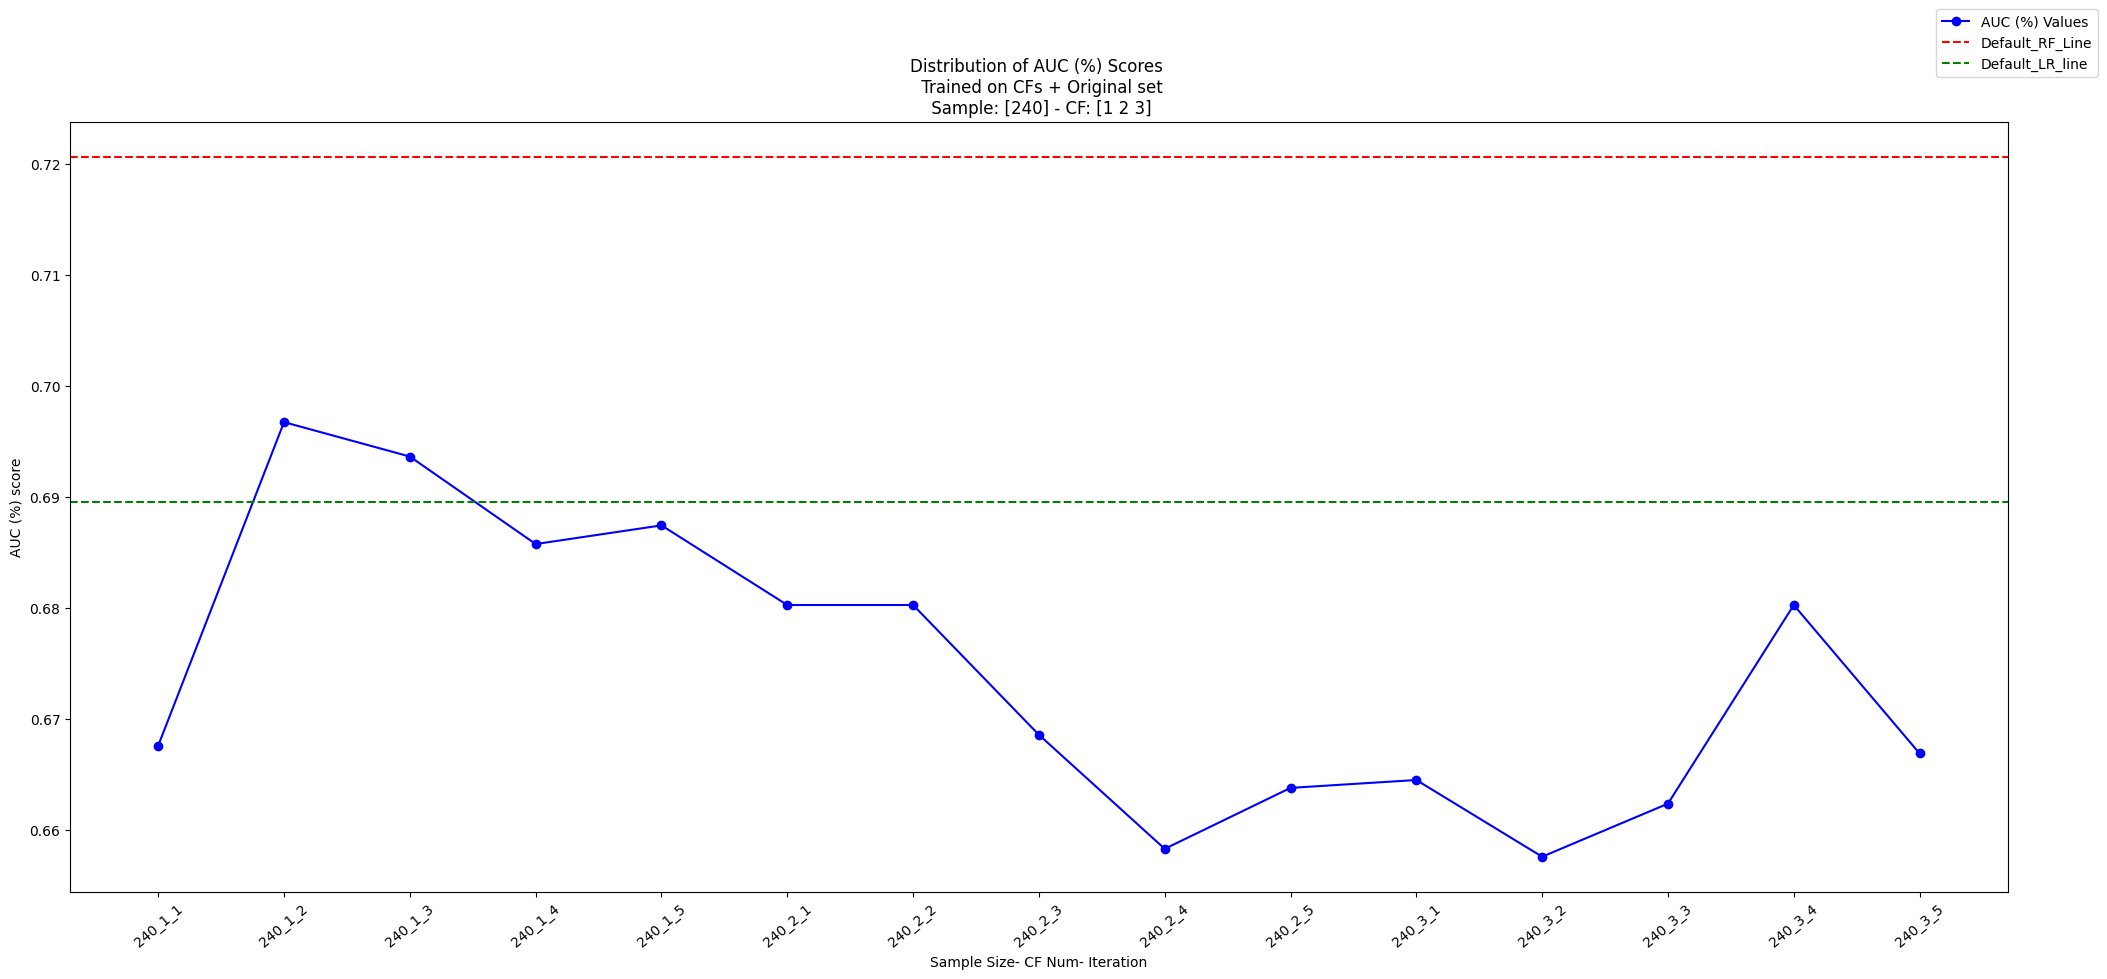

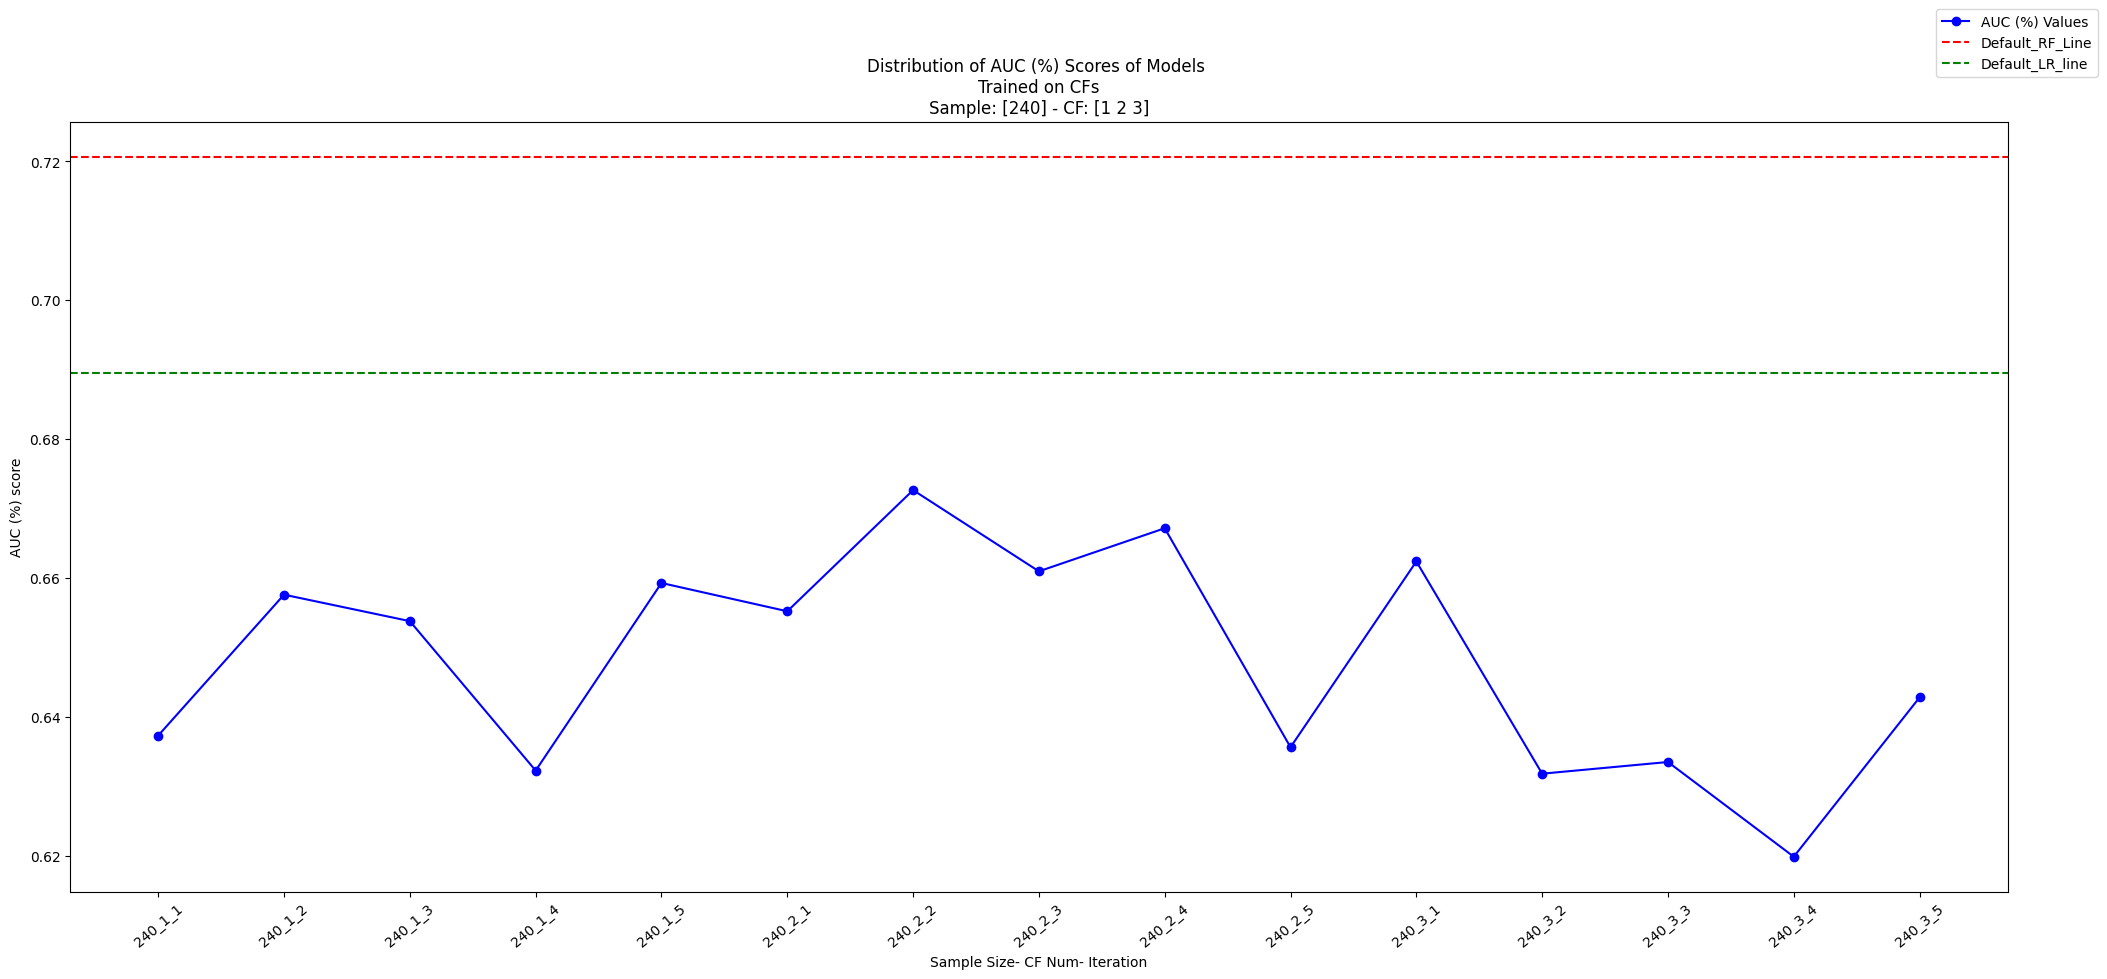

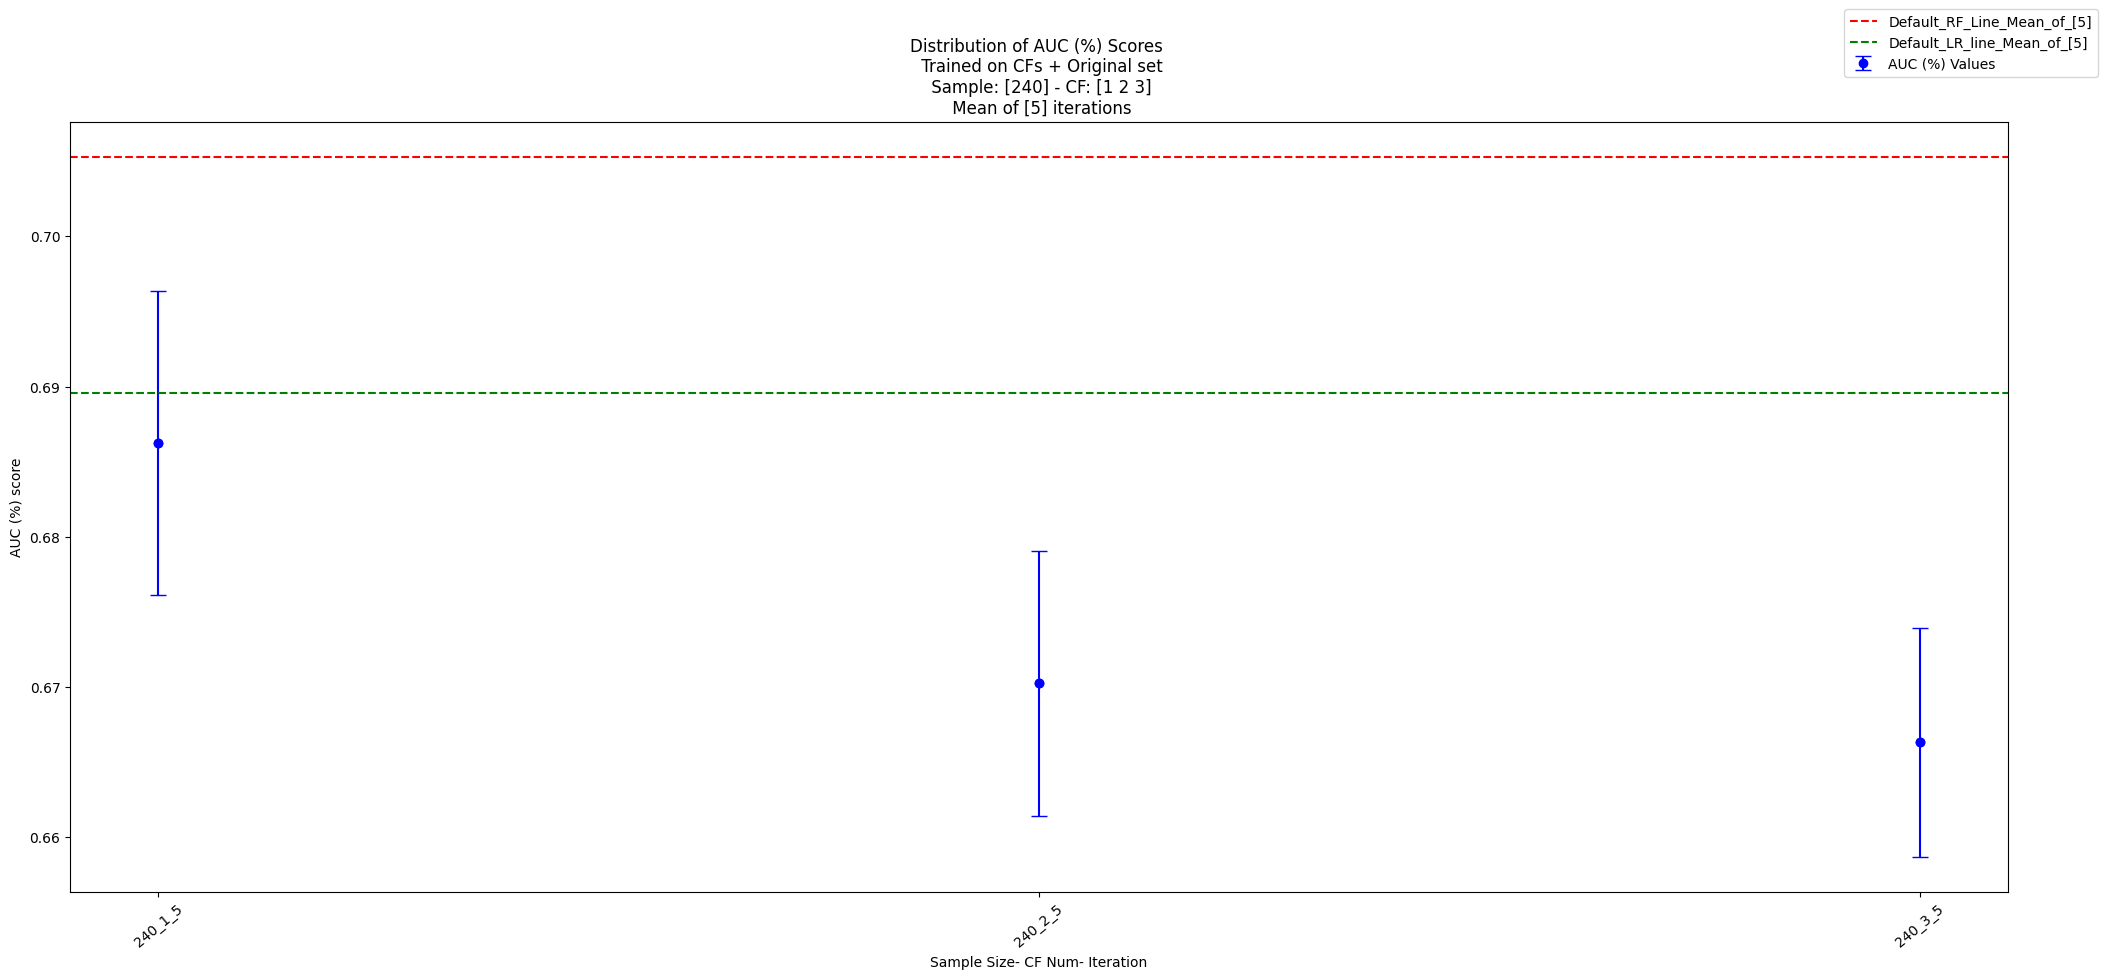

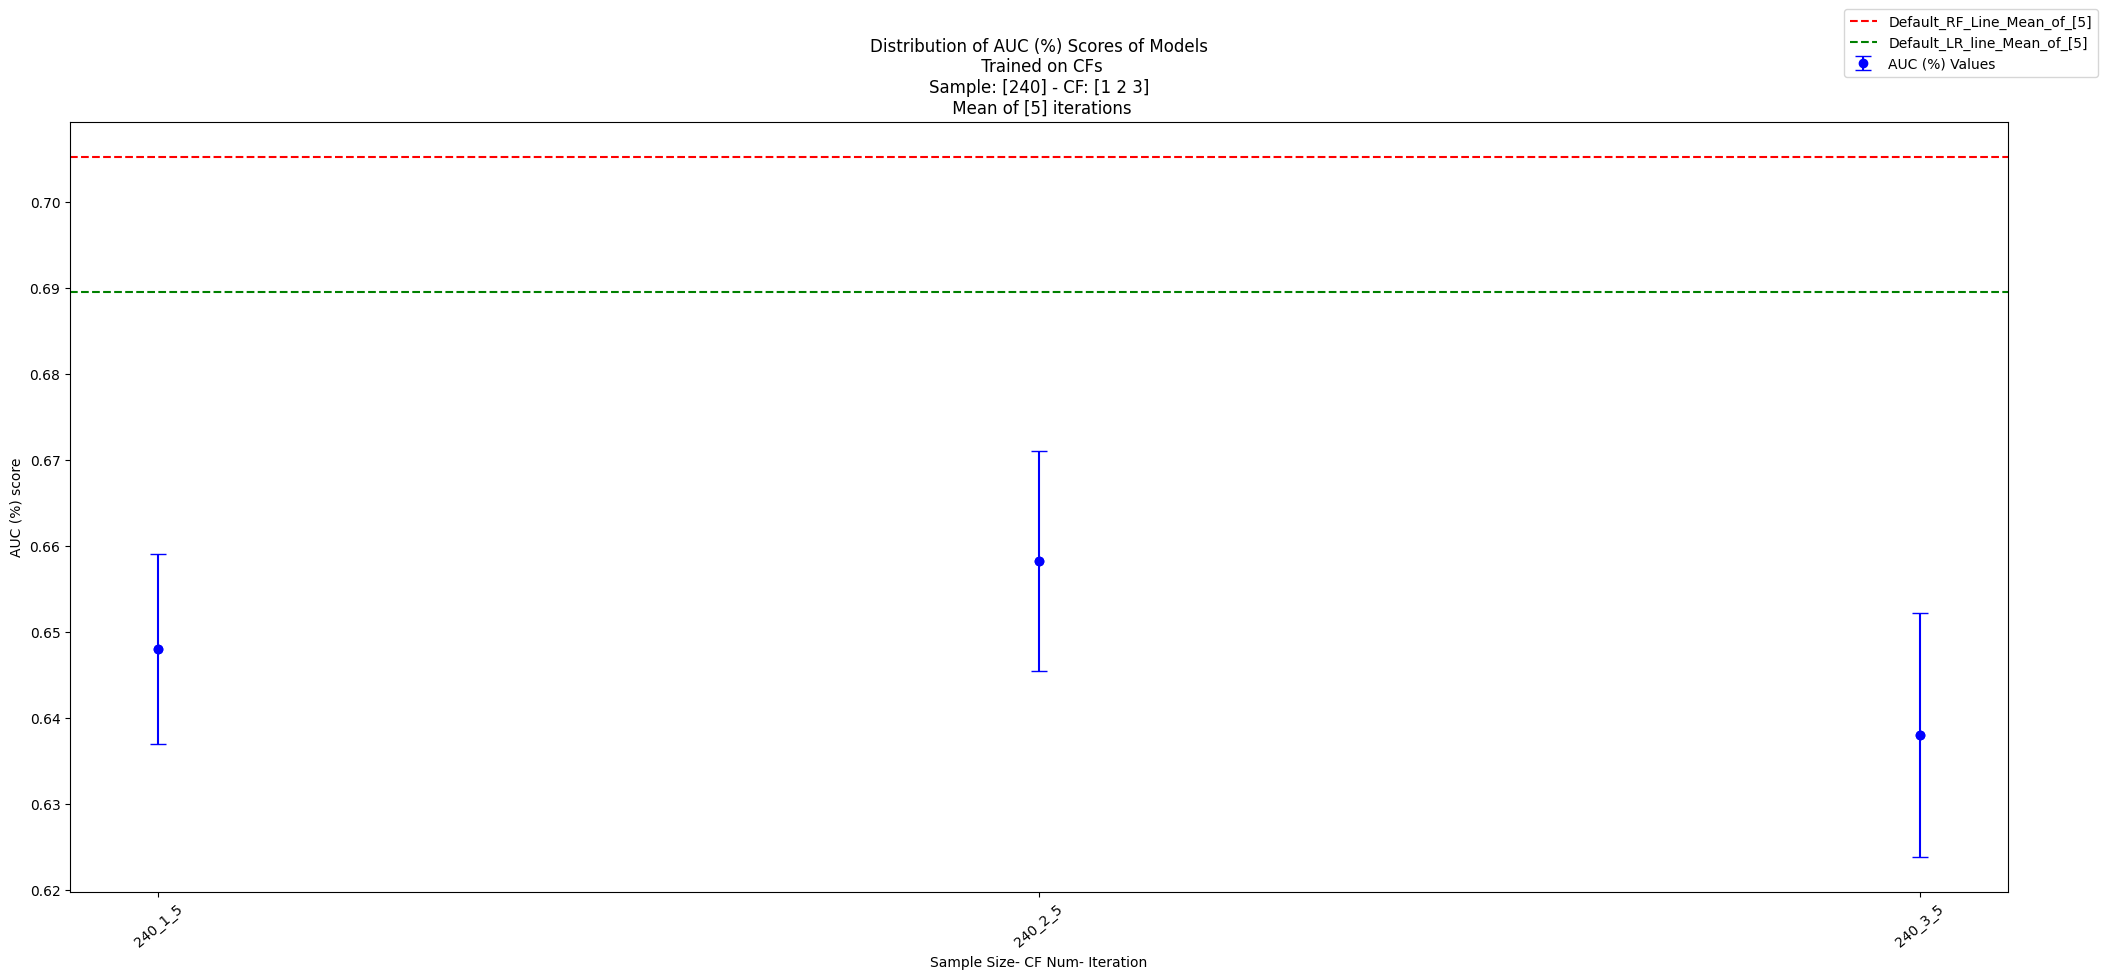

In [30]:
fea_to_vary = 'all'
sample_size_list = [240]
total_CFs_list = [1,2, 3]
iteration_num = 5
list_of_plots = ['AUC (%)'] 

# Running the experiment
model_perf_metrics_merged_only_with_cfs, model_perf_metrics_merged, neww = running_exp(X_fit, y_fit, X_test, y_test, continuous_features, sample_size_list, total_CFs_list, iteration_num, fea_to_vary, '240__1_2_3', list_of_plots)

100%|██████████| 160/160 [00:29<00:00,  5.42it/s]


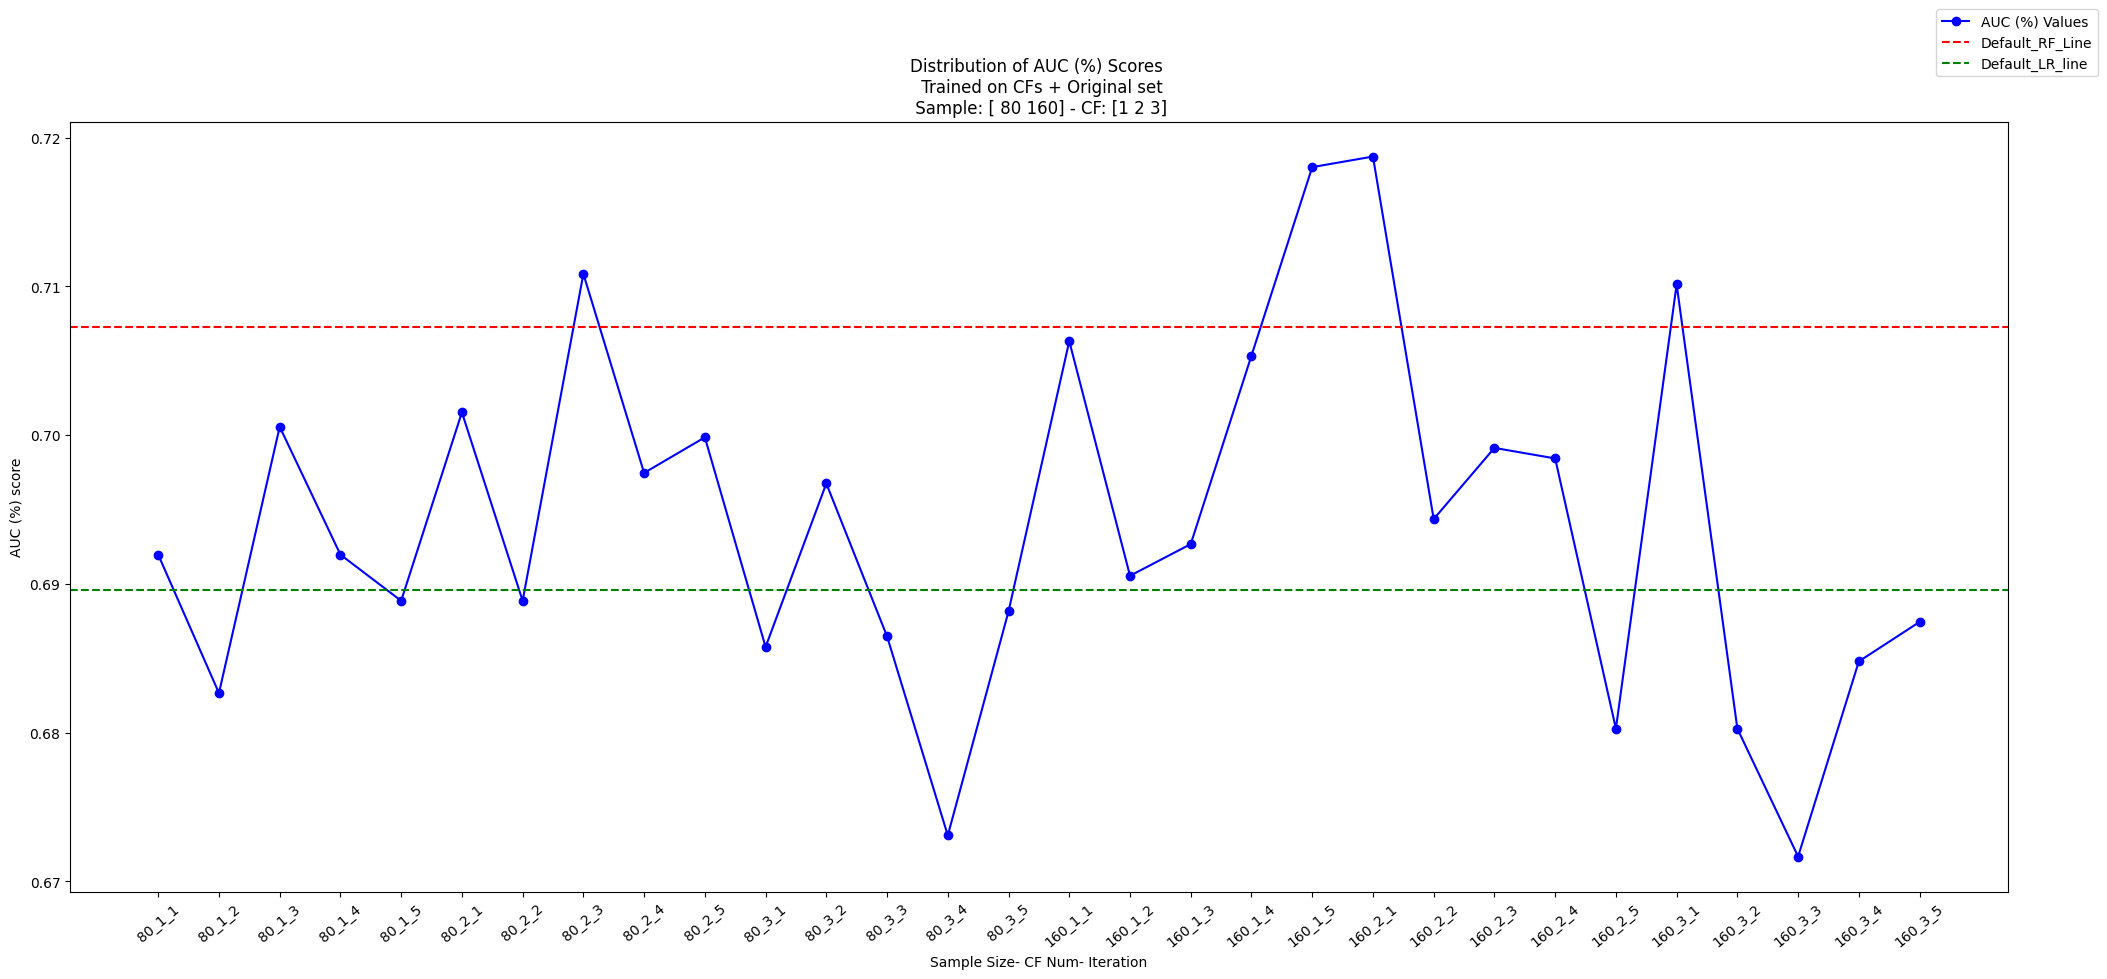

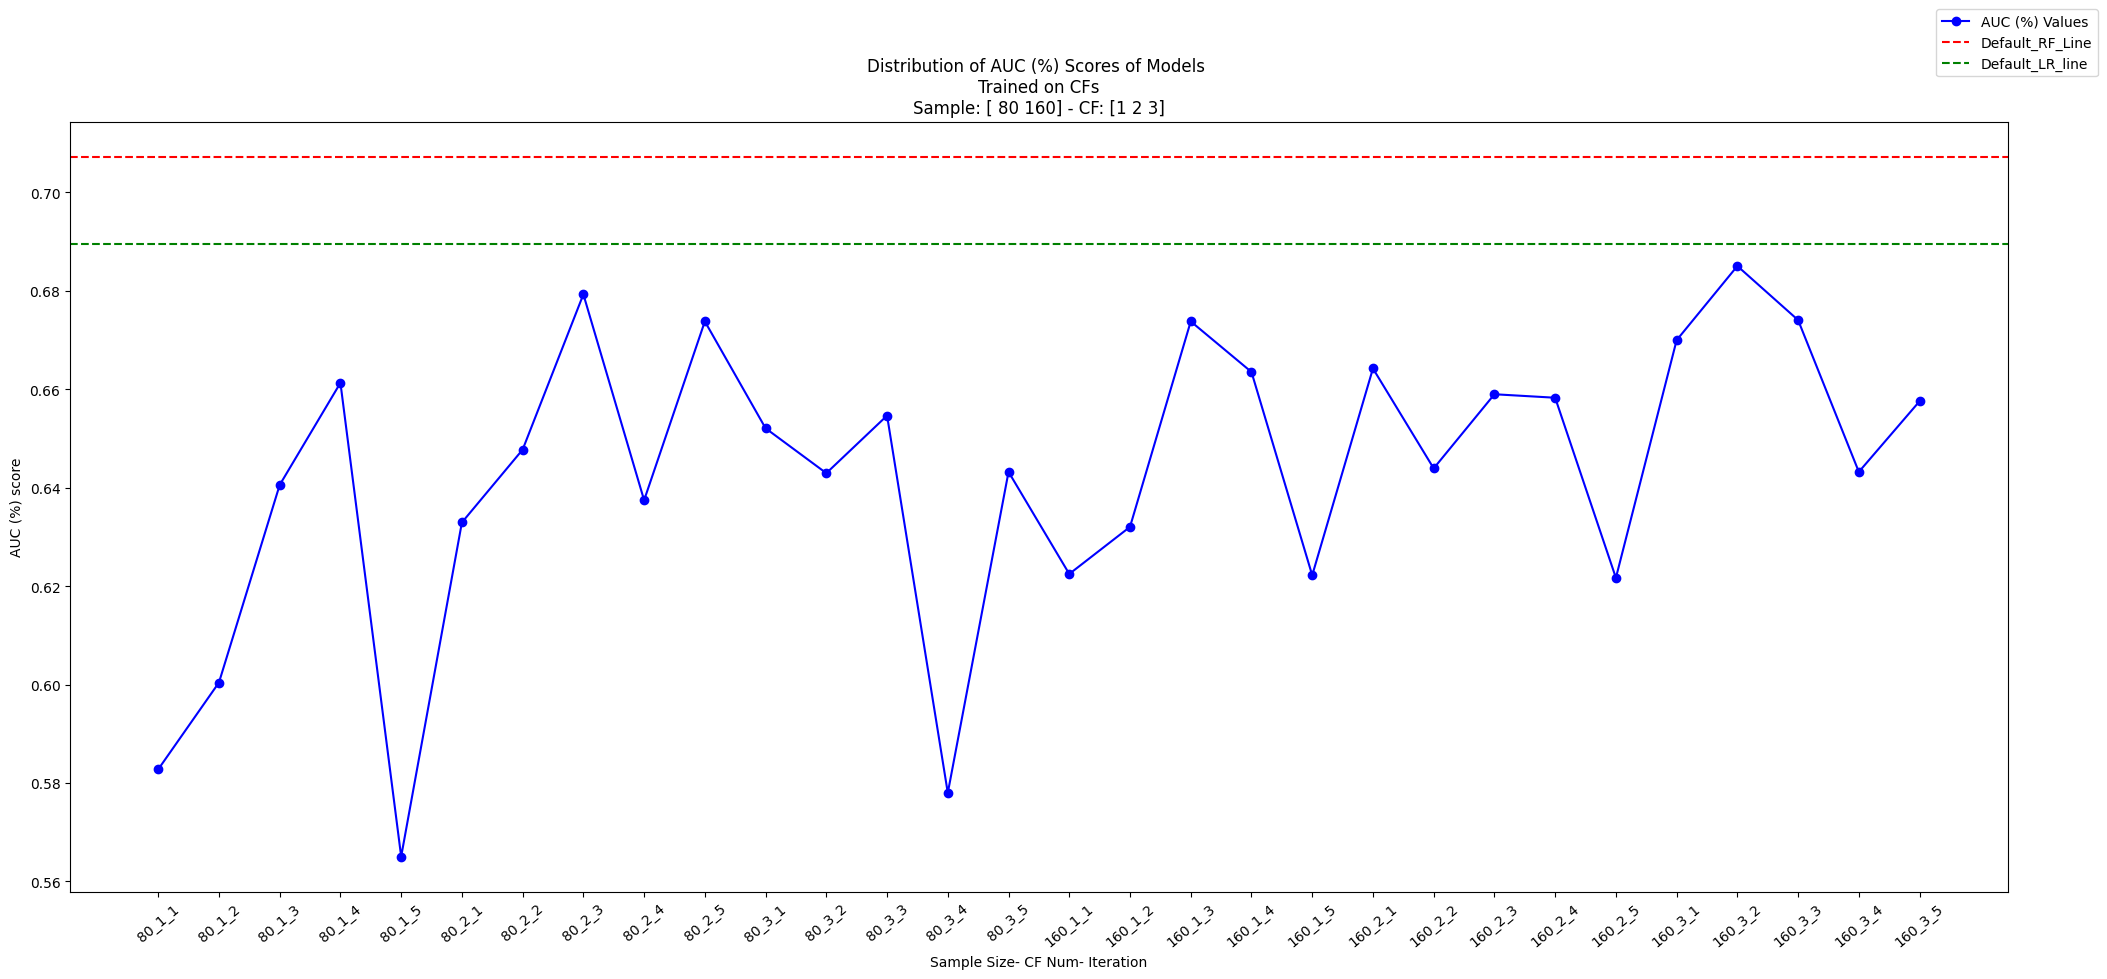

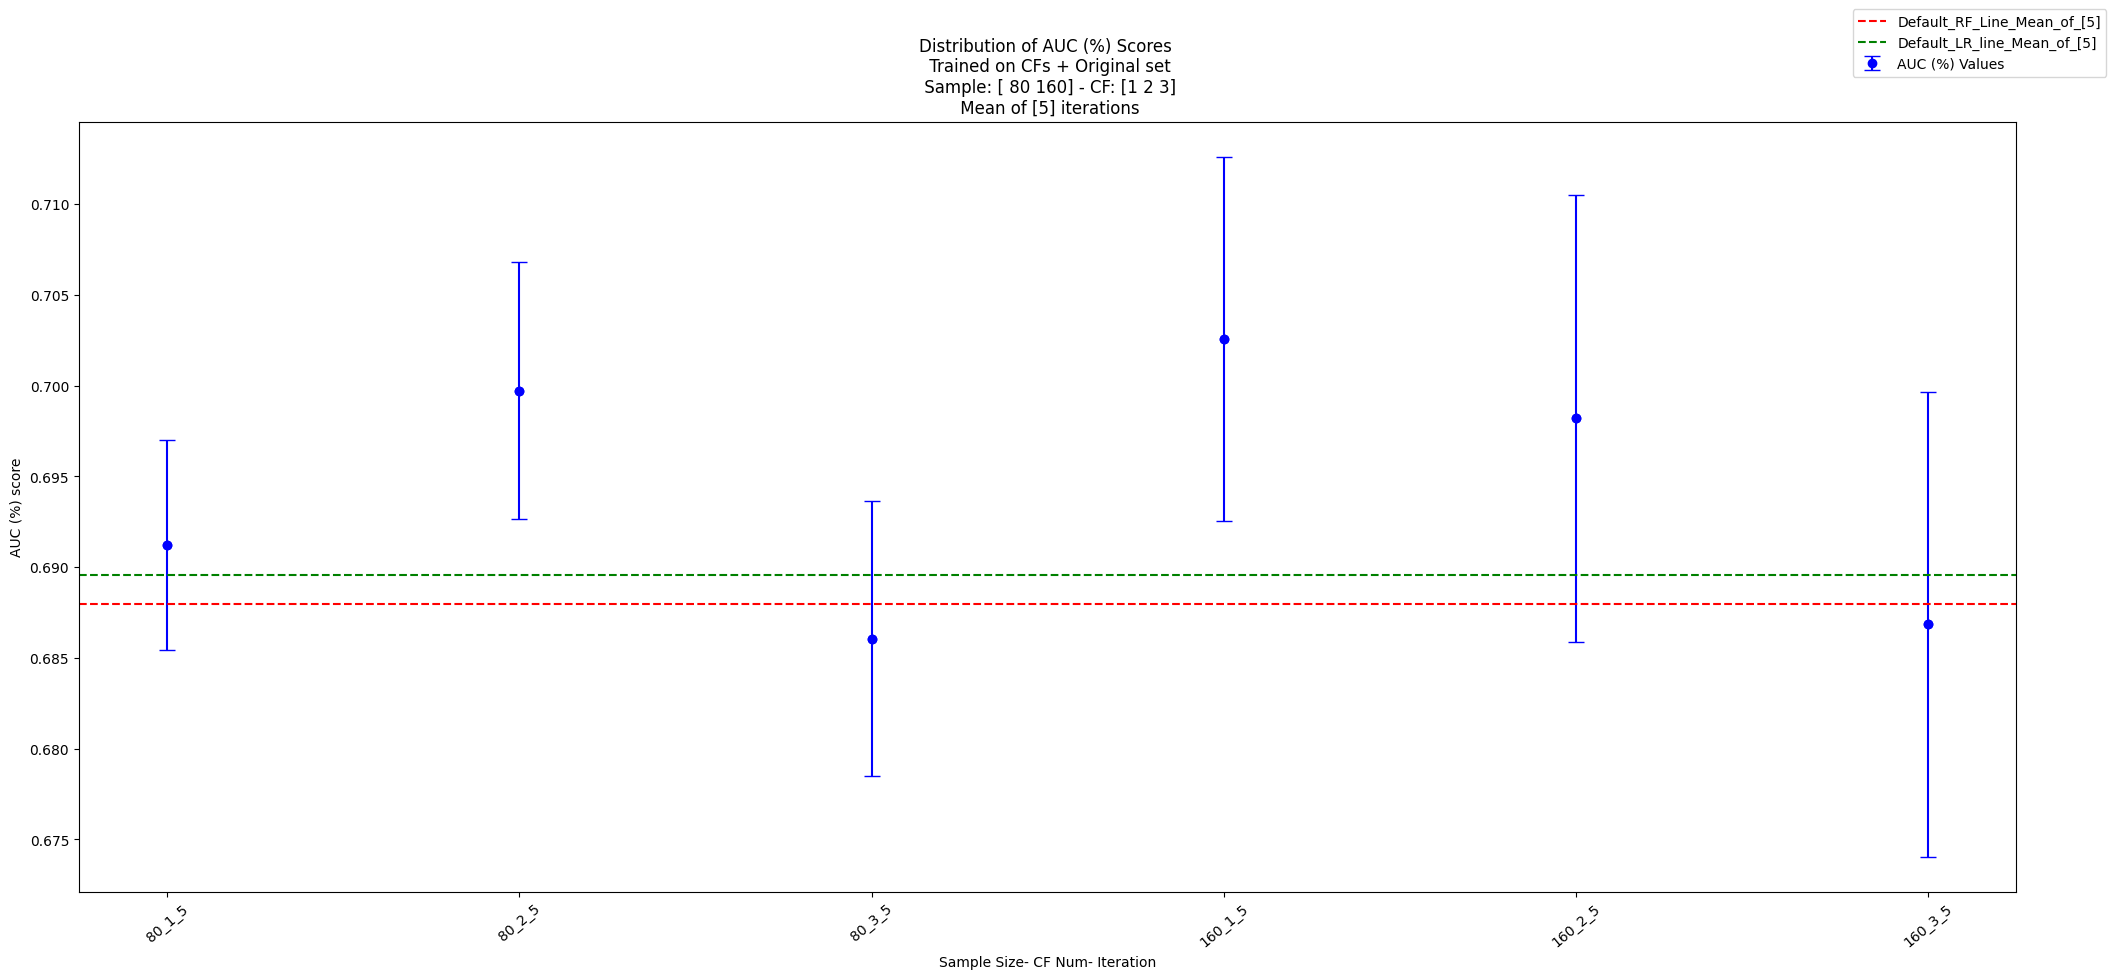

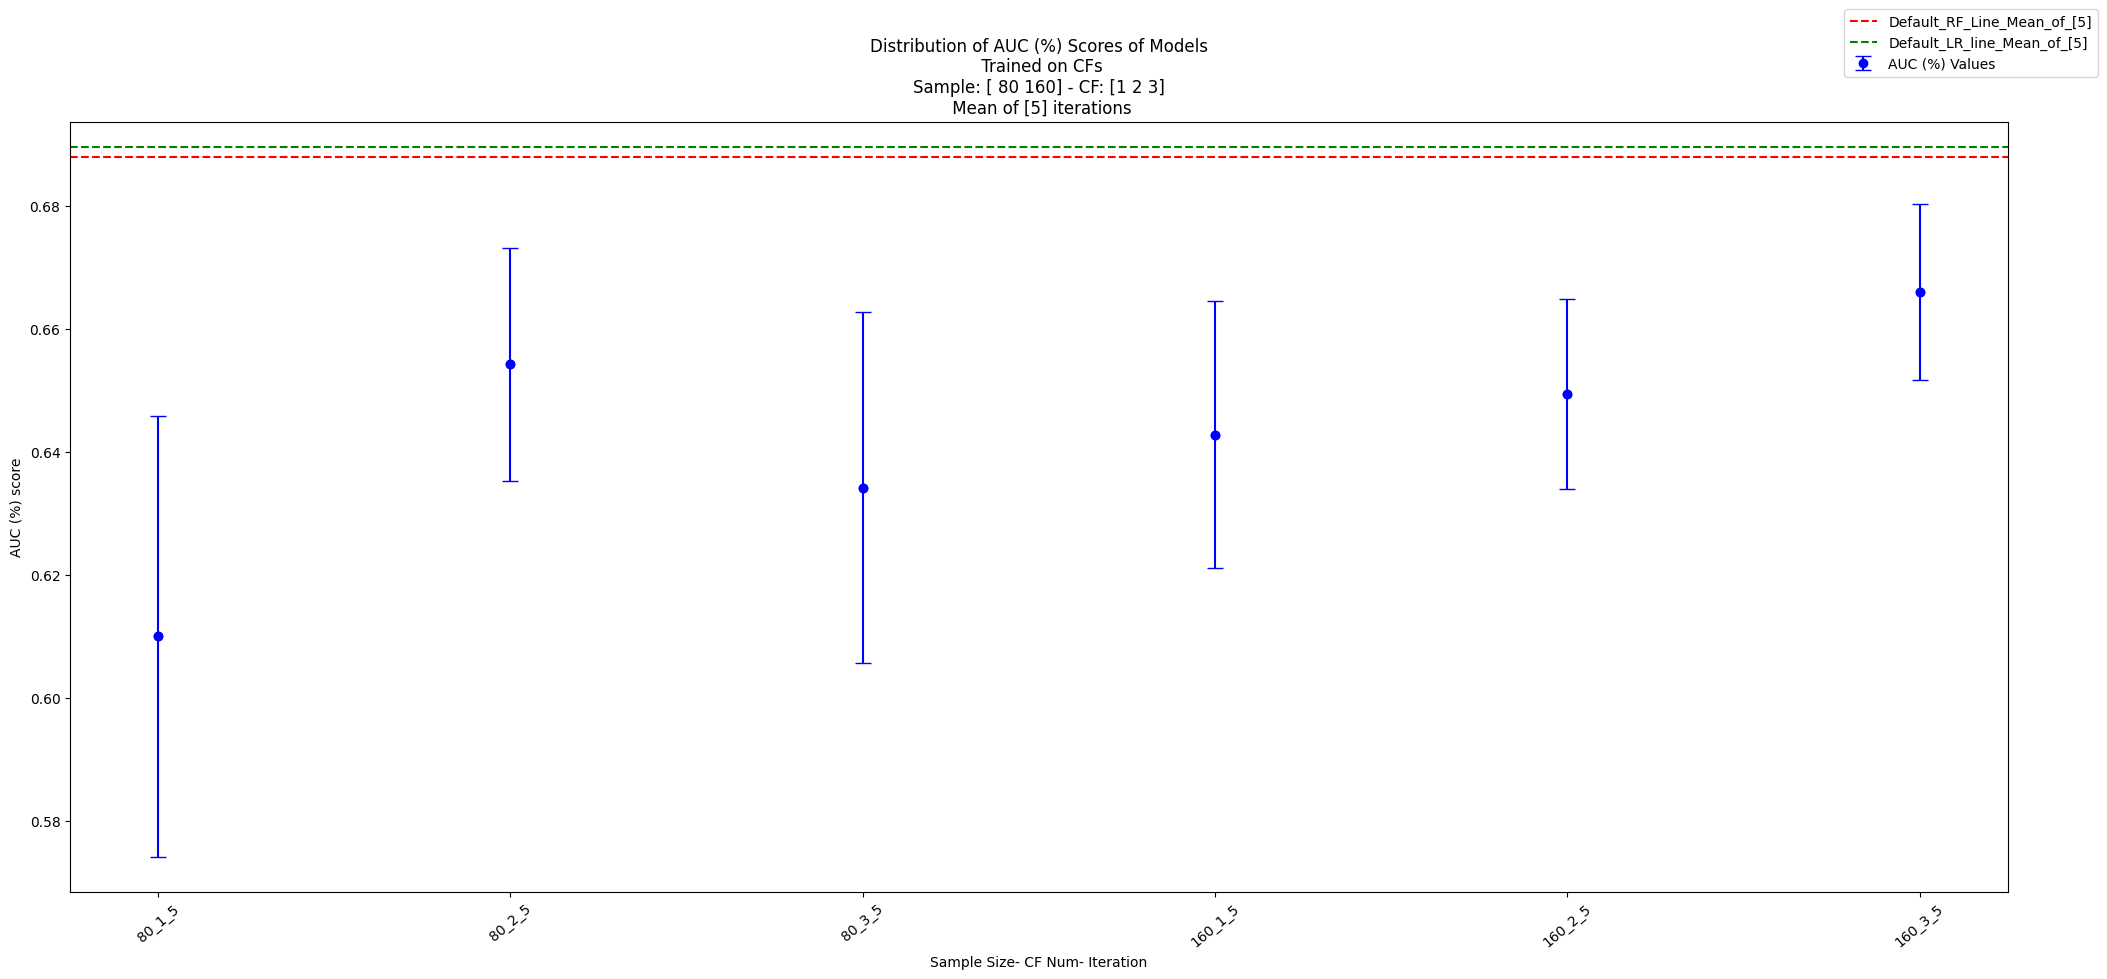

In [ ]:
$$
fea_to_vary = 'all'
sample_size_list = [80, 160]
total_CFs_list = [1,2,3]
iteration_num = 5
list_of_plots = ['AUC (%)'] 

# Running the experiment
model_perf_metrics_merged_only_with_cfs, model_perf_metrics_merged, neww = running_exp(X_fit, y_fit, X_test, y_test, continuous_features, sample_size_list, total_CFs_list, iteration_num, fea_to_vary, '80_160__1_2_3', list_of_plots)